In [1]:
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization
import os
import gc

from scipy.sparse.linalg import eigsh, eigs
import torch.nn.functional as F
from pymatting.util.util import row_sum
from scipy.sparse import diags

In [2]:
# from torch.nn import Linear, GELU

In [3]:
# def flush():
#     gc.collect()
#     torch.cuda.empty_cache()

In [4]:
# del model
# flush()

In [5]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
    "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
}

In [6]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  0#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  0#@param {type:"number"}

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device, jit=False)
# model, preprocess = clip.load("RN50", device=device, jit=False)

In [89]:
image_path = "CLIP/el3.png"
# image_path = "CLIP/rose_garden.jpg"


In [90]:
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
texts = ["an elephant throwing water"]
text = clip.tokenize(texts).to(device)

In [91]:
# text.size()

In [92]:
def get_fev (feats):
    # feats = F.normalize(final_visual_feats.detach().clone().squeeze().cpu(), p = 2, dim = -1)
                    # else:
                        # feats = F.normalize(feats_list[i].detach().clone().squeeze().cpu(), p = 2, dim = -1)[1:-1]

                    # print(f"Features' shape: {feats.shape}")
                    # skew_vec = []
    # image_feats = image_feats.type(torch.float32).cpu()
    # lang_feats = lang_feats.type(torch.float32).cpu()
    feats = feats.type(torch.float32)


    # print(feats.shape)
    # W_feat = feats
    W_feat = (feats @ feats.T)
    W_feat = (W_feat * (W_feat > 0))
    W_feat = W_feat / W_feat.max() 

    W_feat = W_feat.detach().cpu().numpy()


    def get_diagonal (W):
        D = row_sum(W)
        D[D < 1e-12] = 1.0  # Prevent division by zero.
        D = diags(D)
        return D

    D = np.array(get_diagonal(W_feat).todense())

    L = D - W_feat


    try:
        eigenvalues, eigenvectors = eigs(L, k = 5, which = 'LM', sigma = -0.5, M = D)
    except:
        try:
            eigenvalues, eigenvectors = eigs(L, k = 5, which = 'LM', sigma = 0)
        except:
            eigenvalues, eigenvectors = eigs(L, k = 5, which = 'SM')



    eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()
    n_tuple = torch.kthvalue(eigenvalues.real, 2)
                # print(f"N_Tuple: {n_tuple.indices}")
    fev_idx = n_tuple.indices

    return eigenvectors[fev_idx]

In [93]:

def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1: 
      # calculate index of last layer 
      start_layer = len(image_attn_blocks) - 1
    
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    # visual_feats = model.visual.visual_feats
    # R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    # R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    cams = []
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = get_fev(blk.feats[1:, 0, :]) #baka
        # cam = blk.attn_probs.detach()
        # cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        grad = grad.clamp(min=0).mean(dim=0)[1:, 1:]
        cam = torch.abs(cam).unsqueeze(1)
        # print(f"cam shape: {cam.size()}")
        cam = cam.to(device)
        cam = grad * cam
        # print(f"CAM: {cam[:, 0]}")

        # cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        # cam = cam.clamp(min=0).mean(dim=1)
        # R = R + torch.bmm(cam, R)
        cams.append(cam[:, 0])

    image_relevance = torch.stack(cams, dim=0).sum(dim=0)
    # print(image_relevance)

    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    # if start_layer_text == -1: 
    #   # calculate index of last layer 
    #   start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    # R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    # R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    cams1 = []
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        # print(f"texttttttt: {blk.feats.size()}")
        cam = get_fev(blk.feats[:, 0, :])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        grad = grad.clamp(min=0).mean(dim=0)
        cam = torch.abs(cam).unsqueeze(1)
        # print(f"cam shape: {cam.size()}")
        cam = cam.to(device)
        cam = grad * cam
   
        cams1.append(cam)
    text_relevance = torch.stack(cams1, dim=0).sum(dim=0)

    return image_relevance, text_relevance

In [94]:
# list(dict(model.visual.transformer.resblocks.named_children()).values())

In [95]:
image_relevance, text_relevance = interpret(model=model, image=image, texts=text, device=device)


logits image shape: torch.Size([1, 1])


In [96]:
image_relevance.shape

torch.Size([196])

In [97]:
# dim = int(image_relevance.numel() ** 0.5)
# image_relevance = image_relevance.reshape(1, 1, dim, dim)
# image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
# image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
# image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())

In [98]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image)
    axs[0].set_title("Original")
    axs[0].axis('off')

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis)
    axs[1].set_title("Heatmap (DSM + Grad)")
    axs[1].axis('off')

In [99]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  # print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [100]:
text_relevance.size()

torch.Size([77, 77])

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an elephant throwing water


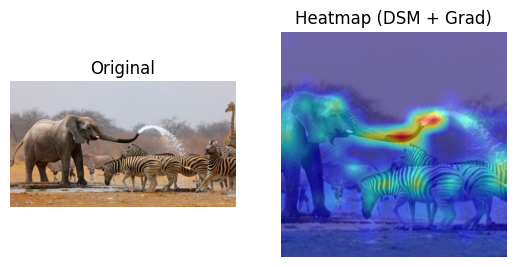

In [101]:
show_heatmap_on_text(texts[0], text[0], text_relevance)
show_image_relevance(image_relevance, image, orig_image=Image.open(image_path))

In [30]:
# def show_cam_on_image(img, mask):
#         heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
#         heatmap = np.float32(heatmap) / 255
#         cam = heatmap + np.float32(img)
#         cam = cam / np.max(cam)
#         return cam


# image1 = image[0].permute(1, 2, 0).detach().cpu().numpy()
# image1 = (image1 - image1.min()) / (image1.max() - image1.min())
# vis = show_cam_on_image(image1, image_relevance)
# vis = np.uint8(255 * vis)
# vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)


# # fig, axs = plt.subplots(ncols=2, figsize=(20, 5))
# plt.imshow(vis)
# plt.axis('off')
# # axs[0].set_title('Spectral Approach Image Relevance')

# # fig, axs = plt.subplots(ncols=2, figsize=(20, 5))
# # axs[0].imshow(vis)
# # axs[0].axis('off')
# # axs[0].set_title('Spectral Approach Image Relevance')

In [139]:
# plt.imshow(image[0][0].cpu())


In [10]:
# plt.imshow(image_relevance)
# image_relevance.shape

(64, 64)